In [1]:
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel
from coupling import *

from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS
from astropy.coordinates import Galactic, FK5, ITRS
from astropy.time import Time
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
import numpy as np

/home/joheenc/anaconda3/envs/genl/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/joheenc/anaconda3/envs/genl/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/joheenc/anaconda3/envs/genl/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a g

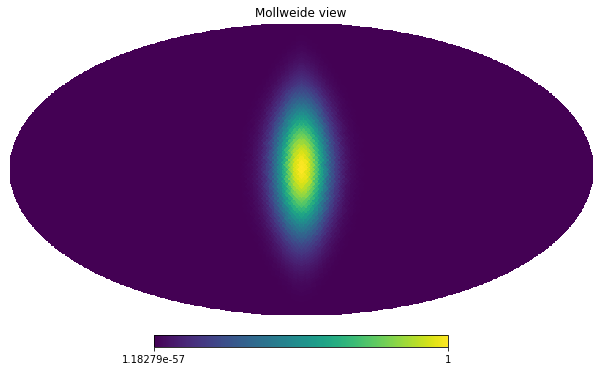

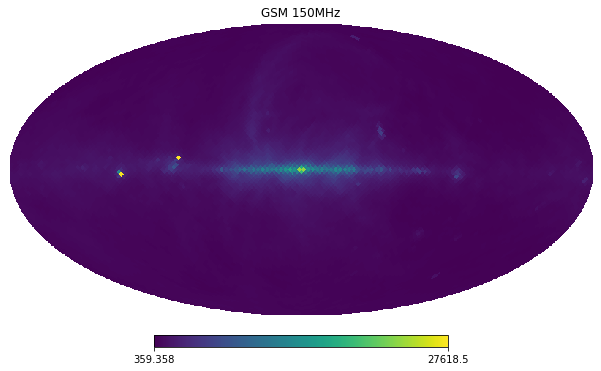

In [5]:
#let's create a gaussian beam (pointed at l=b=0):
beam, angindices, beammap = point_beam(np.pi/2, 0, beamthetastd=0.4, beamphistd=0.2)
nside_beam = hp.npix2nside(len(beammap))
hp.mollview(beammap)

#and use pygdsm to generate a sky map from 50 to 150 MHz
gsm = GlobalSkyModel(freq_unit='MHz')
mapcube = []
for f in range(50,150):
    mapslice = gsm.generate(f)
    mapslice = hp.ud_grade(mapslice, nside_beam)
    mapcube.append(mapslice)
mapcube = np.array(mapcube)
hp.mollview(mapcube[50], title='GSM 150MHz')

In [ ]:
import timeit
#Now we define the orbit in terms of pointing directions in the sky.

# decs = np.linspace(45, 45, nsteps)
# ras = np.linspace(60, 420, nsteps)*norbits % 360
radecs = np.loadtxt('../6monthleo.txt')
psis = np.linspace(0, 0, radecs.shape[1]) % 2*np.pi

tstart = timeit.default_timer()
skycov = sky_coverage(radecs[0, :], radecs[1, :], psis, beamthetastd=0.2, beamphistd=0.4, coordsys='c', nside=32, display=False)
tstop = timeit.default_timer()
print(f'sky coverage computed in {tstop-tstart} seconds')
hp.mollview(np.sum(skycov, axis=0))

sky coverage computed in 2160.3929965999996 seconds


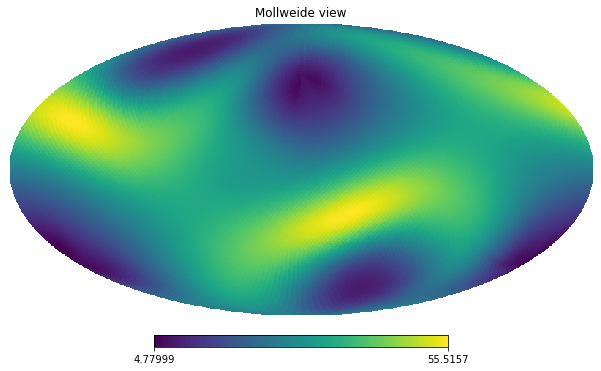

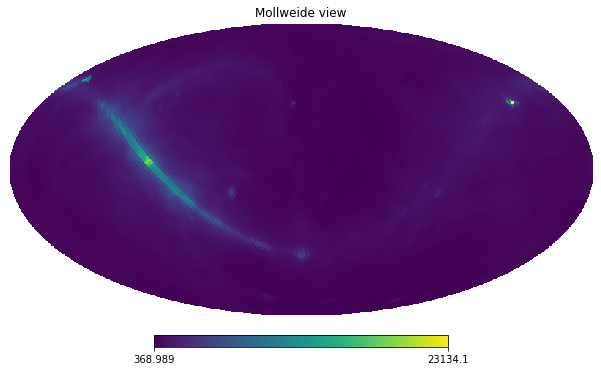

In [7]:
#a critical step will be to rotate the beam coverage and the sky to a frame where the velocity dipole is in the z-direction:
skycov_dipole = gal_to_dipole(np.sum(skycov, axis=0))
skymap_dipole = gal_to_dipole(mapcube[50])
hp.mollview(skycov_dipole)
hp.mollview(skymap_dipole)

coupling matrix computed in 5.176144799999747 seconds


/home/joheenc/anaconda3/envs/genl/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


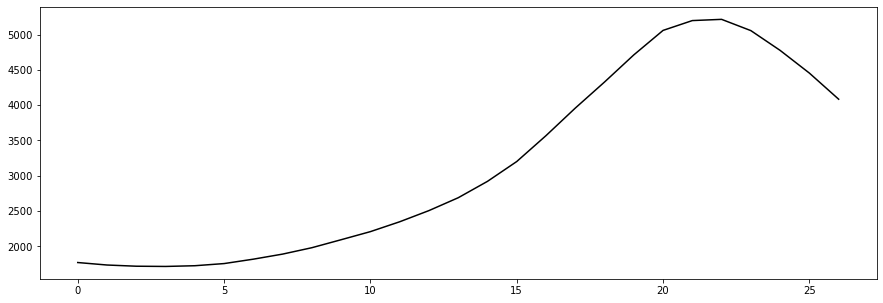

In [9]:
tstart = timeit.default_timer()
blm = np.array([hp.map2alm(gal_to_dipole(bstep), lmax=15) for bstep in skycov])
tstop = timeit.default_timer()
print(f'coupling matrix computed in {tstop-tstart} seconds')
alm = hp.map2alm(gal_to_dipole(mapcube[0]), lmax=15)
Plm = blm @ alm
plt.figure(figsize=(15, 5))
plt.plot(Plm[:len(Plm)//(norbits//10)], color='black')
plt.show()

In [83]:
hp.sphtfunc.Alm.getlm(15, 46)

(4, 3)

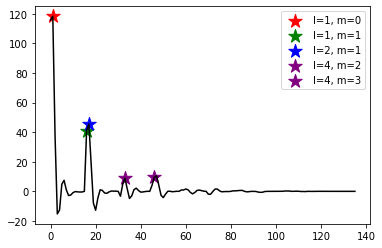

In [84]:
realcorrs, imagcorrs = compute_corr(blm)
plt.plot(realcorrs, color='black')
plt.scatter(1, realcorrs[1], color='red', marker='*', s=200, label='l=1, m=0')
plt.scatter(16, realcorrs[16], color='green', marker='*', s=200, label='l=1, m=1')
plt.scatter(17, realcorrs[17], color='blue', marker='*', s=200, label='l=2, m=1')
plt.scatter(33, realcorrs[33], color='purple', marker='*', s=200, label='l=4, m=2')
plt.scatter(46, realcorrs[46], color='purple', marker='*', s=200, label='l=4, m=3')
plt.legend()